# Settings and import of the dataset

In [1]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
import csv 
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, cross_val_predict, cross_validate, StratifiedKFold
from sklearn.metrics import mean_squared_error,confusion_matrix,ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, SelectKBest, f_classif, mutual_info_classif

kf = KFold(n_splits=5, shuffle=True, random_state=42)

pd.set_option('display.max_rows', None)  # to show all rows
pd.set_option('display.max_columns', None)  # to show all columns

In [ ]:
# import CarpeDiem dataset
dataset_original = pd.read_csv('CarpeDiem_dataset.csv')
dataset_original = pd.DataFrame(dataset_original)
dataset_original.head()

In [ ]:
dataset_original.shape

In [4]:
dataset_original.describe()

,Patient_id,External_transfer_flag,Binary_outcome,Age,BMI,Admit_APS_score,Admit_SOFA_score,Cumulative_ICU_days,Number_of_ICU_stays,Tracheostomy_flag,Cumulative_intubation_days,ICU_stay,ICU_day,SOFA_score,ECMO_flag,Intubation_flag,Hemodialysis_flag,CRRT_flag,Temperature,Heart_rate,Systolic_blood_pressure,Diastolic_blood_pressure,Mean_arterial_pressure,Norepinephrine_rate,Norepinephrine_flag,Respiratory_rate,Oxygen_saturation,Urine_output,GCS_eye_opening,GCS_motor_response,GCS_verbal_response,RASS_score,PEEP,FiO2,Plateau_Pressure,Lung_Compliance,PEEP_changes,Respiratory_rate_changes,FiO2_changes,ABG_pH,ABG_PaCO2,ABG_PaO2,PaO2FIO2_ratio,WBC_count,Lymphocytes,Neutrophils,Hemoglobin,Platelets,Bicarbonate,Creatinine,Albumin,Bilirubin,CRP,D_dimer,Ferritin,LDH,Lactic_acid,Procalcitonin,Episode_duration
count,12495.000000,12495.000000,12495.000000,12495.000000,12489.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12495.000000,12482.000000,12493.000000,12489.000000,12486.000000,12415.000000,4510.000000,12495.000000,12407.000000,12483.000000,10560.000000,12375.000000,12375.000000,12375.000000,11455.000000,10254.000000,10297.000000,9624.000000,9490.000000,10328.000000,10328.000000,10328.000000,7366.000000,7363.000000,7365.000000,8655.000000,12253.000000,8684.000000,8757.000000,12171.000000,12339.000000,12184.000000,12220.000000,9371.000000,9306.000000,3095.000000,4093.000000,2503.000000,4884.000000,5236.000000,3836.000000,520.000000
mean,4698.855462,0.414886,0.519168,58.867227,29.685186,85.186955,10.740136,44.468267,1.419528,0.538055,41.086034,1.218808,21.535974,8.708764,0.194638,0.843377,0.051701,0.148699,98.658200,90.697047,119.310300,60.437508,64.002175,0.128788,0.360944,23.343534,96.347616,1394.620218,2.654061,3.932768,1.773657,-1.876604,8.670378,45.293132,25.044455,25.681924,1.615221,1.944520,1.869868,7.395831,45.314019,97.730739,190.441739,12.651123,1.105870,9.688397,8.849277,204.751763,27.064215,1.348228,2.777880,1.352911,155.168533,4359.253013,1223.155733,461.907757,1.706331,2.770665,8.144231
std,2868.677789,0.492722,0.499652,14.567855,7.900224,31.027350,3.997070,47.358721,0.897537,0.498570,47.755191,0.629677,30.177074,4.654298,0.395938,0.363459,0.221431,0.355806,1.116889,17.118899,16.661961,9.783606,11.341311,0.108735,0.480294,5.922778,2.609185,1124.144962,1.286439,2.175582,1.505526,1.904690,4.240833,16.881449,6.783038,15.130991,0.997959,1.264911,1.070259,0.072107,11.626437,36.032468,104.309716,7.595576,0.846818,6.441786,1.665425,138.163386,5.633402,1.197936,0.567048,1.985188,110.860420,6135.491643,1397.045869,263.234497,1.044975,6.025249,6.631824
min,43.000000,0.000000,0.000000,19.000000,11.410000,22.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.180000,41.625000,31.000000,23.000000,20.000000,0.003621,0.000000,1.000000,52.500000,0.000000,1.000000,1.000000,1.000000,-5.000000,0.000000,21.000000,7.000000,0.000000,1.000000,1.000000,1.000000,6.920000,16.142857,31.000000,1.760000,0.100000,0.000000,0.000000,5.000000,1.000000,7.750000,0.200000,1.500000,0.100000,1.000000,150.000000,14.400000,85.000000,0.300000,0.050000,1.000000
25%,2116.000000,0.000000,0.000000,51.000000,24.750000,60.000000,8.000000,17.000000,1.000000,0.000000,13.000000,1.000000,5.000000,5.000000,0.000000,1.000000,0.000000,0.000000,98.000000,78.206897,107.977273,53.819192,58.000000,0.050088,0.000000,19.240000,94.852397,534.500000,1.000000,1.000000,1.000000,-4.000000,5.000000,32.000000,19.750000,13.875000,1.000000,1.000000,1.000000,7.352857,37.267857,75.428571,117.140000,7.800000,0.500000,5.400000,7.650000,98.000000,23.000000,0.570000,2.400000,0.400000,62.000000,848.000000,438.400000,297.000000,1.033333,0.234750,5.000000
50%,4474.000000,0.000000,1.000000,60.000000,28.700000,90.000000,11.000000,31.000000,1.000000,1.000000,27.000000,1.000000,12.000000,9.000000,0.000000,1.000000,0.000000,0.00

In [6]:
# Create the new dataframe
dataset_df = pd.read_csv('CarpeDiem_dataset.csv')
dataset_df = pd.DataFrame(dataset_df)

# 'ICU_stay'
To uniform the dataset, we decide to remove the patients who present at least one stay longer than 31 days.

In [7]:
# Check the presence of patients with a stay longer than 31 days:
length_stays = dataset_df.groupby(['Patient_id', 'ICU_stay'])['ICU_day'].max()
length_stays = pd.DataFrame(length_stays).reset_index()
print(length_stays.columns)

Index(['Patient_id', 'ICU_stay', 'ICU_day'], dtype='object')


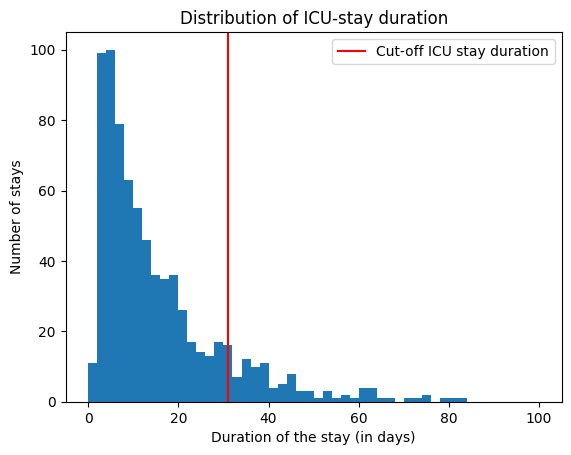

In [8]:
# Plot the distribution of ICU-stays duration
dist_stay = length_stays['ICU_day']
plt.hist(dist_stay,bins = 50,  range= (0, 100), histtype='bar')
plt.axvline(x=31, color='red', label='Cut-off ICU stay duration')

plt.title('Distribution of ICU-stay duration')
plt.xlabel('Duration of the stay (in days)')
plt.ylabel('Number of stays')
plt.legend()

In [9]:
# Find IDs of patients with at least a stay longer than 31 days
patients_too_long = length_stays.loc[(length_stays['ICU_day'])>31, 'Patient_id'].unique()
print(f"There are {len(patients_too_long)} patients (out of 585) with a stay longer than 31 days")

# Remove from the original dataset the patients with at least a stay longer than 31 days
dataset_df = dataset_df[~ dataset_df['Patient_id'].isin(patients_too_long)]
dataset_df = dataset_df.reset_index(drop=True)
print(dataset_df.shape)

There are 96 patients (out of 585) with a stay longer than 31 days
(7089, 73)


# 'Age' and 'BMI' distributions
We look at distributions of variables 'Age' and 'BMI'; we decide to remove patients who present a too extreme value of these variables, in order to obtain a more uniform dataset, in particular:
- as regards variable 'Age' we choose to remove patients who are younger than 30 years old, since they are a minority, and patients who are over 80 years
old (who include also all the patients older than 89, labeled as 91), because they are likely to have other pathologies/comorbidities/complications due to age, that are not reported in the dataset.
- as regards variable 'BMI' we choose to remove patients with BMI larger than 60, because they represent extreme cases.

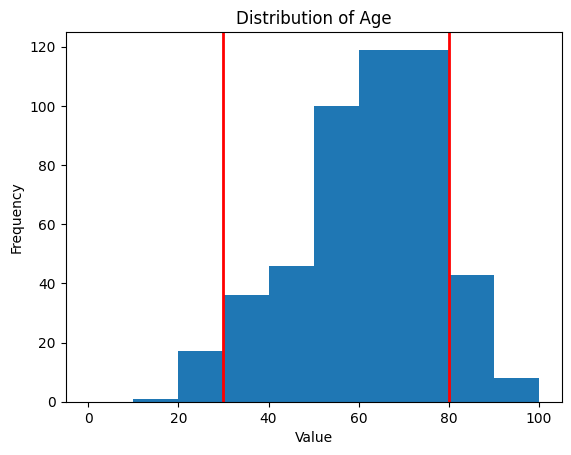

(6262, 73)


In [10]:
# Age
bins_Age = np.arange(0, 101, 10)
plt.hist(dataset_df['Age'].groupby(dataset_df['Patient_id'], group_keys= True).first(), bins=bins_Age, histtype='bar')
plt.axvline(x=30, color='red', lw=2)
plt.axvline(x=80, color='red', lw=2)

plt.title(f'Distribution of Age')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

dataset_df = dataset_df[((dataset_df['Age']>=30) & (dataset_df['Age']<=80))]
dataset_df = dataset_df.reset_index(drop=True)
print(dataset_df.shape)

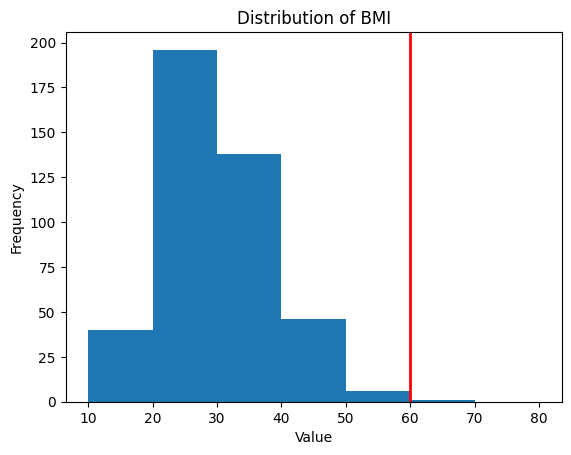

(6209, 73)


In [11]:
# BMI 
bins_BMI = np.arange(10, 90, 10)
plt.hist(dataset_df['BMI'].groupby(dataset_df['Patient_id'], group_keys= True).first(), bins=bins_BMI, histtype='bar')
plt.axvline(x=60, color='red', lw=2)
plt.title(f'Distribution of BMI')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

dataset_df = dataset_df[(dataset_df['BMI'] <60)]
dataset_df = dataset_df.reset_index(drop=True)
print(dataset_df.shape)

# NaN analysis
We consider the null values present in the dataset and we analyse them one variable at a time.

In [12]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6209 entries, 0 to 6208
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Patient_id/ICU_stay/ICU_day  6209 non-null   object 
 1   Patient_id                   6209 non-null   int64  
 2   External_transfer_flag       6209 non-null   int64  
 3   Admission_source_name        6209 non-null   object 
 4   Discharge_disposition        6209 non-null   object 
 5   Binary_outcome               6209 non-null   int64  
 6   Global_cause_failure         2671 non-null   object 
 7   Patient_category             6209 non-null   object 
 8   COVID_status                 6209 non-null   bool   
 9   Age                          6209 non-null   int64  
 10  Ethnicity                    6209 non-null   object 
 11  Gender                       6209 non-null   object 
 12  Race                         6209 non-null   object 
 13  Smoking_status    

In [13]:
# Percentage of null values in each column
percentage_null_columns = dataset_df.isnull().mean() * 100
percentage_null_columns

Patient_id/ICU_stay/ICU_day     0.000000
Patient_id                      0.000000
External_transfer_flag          0.000000
Admission_source_name           0.000000
Discharge_disposition           0.000000
Binary_outcome                  0.000000
Global_cause_failure           56.981801
Patient_category                0.000000
COVID_status                    0.000000
Age                             0.000000
Ethnicity                       0.000000
Gender                          0.000000
Race                            0.000000
Smoking_status                  0.000000
BMI                             0.000000
Admit_APS_score                 0.000000
Admit_SOFA_score                0.000000
Cumulative_ICU_days             0.000000
Number_of_ICU_stays             0.000000
Tracheostomy_flag               0.000000
Cumulative_intubation_days      0.000000
ICU_stay                        0.000000
ICU_day                         0.000000
SOFA_score                      0.000000
ECMO_flag       

## 'Global_cause_failure' 

We decide to remove this variable since it has 56% of null values and it can't be used as a covariate in our model but only as a possible target.

In [14]:
dataset_df.drop(['Global_cause_failure'], axis=1, inplace=True)
dataset_df.shape

(6209, 72)

## 'Norepinephrine_rate'
This feature's null values are missing not at random, in fact we notice that when 'Norepinephrine_flag' is 0, 'Norepinephrine_rate' is null; so by looking at 'Norepinephrine_flag', we decide to substitute the null values with 0 if 'Norepinephrine_flag' is 0, since the patient has not received the drug.

In [15]:
for i in range(len(dataset_df)):
    if (dataset_df.loc[i, 'Norepinephrine_flag'] == 0) & (np.isnan(dataset_df.loc[i, 'Norepinephrine_rate'])):
        dataset_df.loc[i, 'Norepinephrine_rate'] = 0
    elif (dataset_df.loc[i, 'Norepinephrine_flag'] == 0) & (~np.isnan(dataset_df.loc[i, 'Norepinephrine_rate'])):
        print(dataset_df.loc[i, 'Norepinephrine_rate'])

## 'PEEP'
This feature's null values are missing not at random, in fact we notice that when 'Intubation_flag' is 0, 'PEEP' is null; so by looking at 'Intubation_flag', we decide to substitute the null values with 0 if 'Intubation_flag' is 0, since the patient is not intubated. \
If 'Intubation_flag' is 1 and 'PEEP_changes' != 0, we consider 'PEEP' != 0, so we transform it into a null value in order to impute it later.

In [16]:
for i in range(len(dataset_df)):
    if (dataset_df.loc[i, 'Intubation_flag'] == 0) & (np.isnan(dataset_df.loc[i,'PEEP'])):
        dataset_df.loc[i, 'PEEP'] = 0.0
    elif (dataset_df.loc[i, 'Intubation_flag'] == 0) & (~np.isnan(dataset_df.loc[i, 'PEEP'])):
        print(dataset_df.loc[i, ['Patient_id','Intubation_flag','PEEP']])
    elif (dataset_df.loc[i, 'Intubation_flag'] == 1) & (dataset_df.loc[i, 'PEEP_changes']>1e-1) & (dataset_df.loc[i, 'PEEP']<1e-1):
        dataset_df.loc[i, 'PEEP'] = np.nan

Patient_id         1705
Intubation_flag       0
PEEP                5.0
Name: 1276, dtype: object
Patient_id         1705
Intubation_flag       0
PEEP                5.0
Name: 1277, dtype: object
Patient_id         1705
Intubation_flag       0
PEEP                5.0
Name: 1278, dtype: object
Patient_id         1705
Intubation_flag       0
PEEP                5.0
Name: 1279, dtype: object
Patient_id         1705
Intubation_flag       0
PEEP                5.0
Name: 1280, dtype: object


In [17]:
# we look at patient 1705 who presents an anomaly
dataset_df.loc[dataset_df['Patient_id']==1705,['Intubation_flag','PEEP']]

,Intubation_flag,PEEP
1276,0,5.0
1277,0,5.0
1278,0,5.0
1279,0,5.0
1280,0,5.0
1281,0,0.0
1282,0,0.0
1283,0,0.0
1284,0,0.0
1285,0,0.0


In [18]:
# since for the first 5 days the value of PEEP is recorded, even if Intubation_flag is 0 we decide to put Intubation_flag to 1
dataset_df.loc[ ((dataset_df['Patient_id'] == 1705) & (dataset_df['Intubation_flag']==0) & (dataset_df['PEEP'] != 0)), 'Intubation_flag'] = 1

## 'FiO2'
We notice that if the patient is not intubated, i.e. if 'Intubation_flag' is 0, the measurements of 'FiO2' are never reported. So we decide to substitute these missing values with 0 when 'Intubation_flag' is 0.

In [19]:
for i in range(len(dataset_df)):
    if (dataset_df.loc[i, 'Intubation_flag'] == 0) & (np.isnan(dataset_df.loc[i,'FiO2'])):
        dataset_df.loc[i, 'FiO2'] = 0.0
    elif (dataset_df.loc[i, 'Intubation_flag'] == 0) & (~np.isnan(dataset_df.loc[i, 'FiO2'])):
        print(dataset_df.loc[i, ['Patient_id','FiO2']])

Patient_id    2016
FiO2          30.0
Name: 1556, dtype: object


## 'Plateau_Pressure'
We notice that if the patient is not intubated, i.e. if 'Intubation_flag' is 0, the measurements of 'Plateau_Pressure' are never reported. So we decide to substitute these missing values with 0 when 'Intubation_flag' is 0.

In [20]:
for i in range(len(dataset_df)):
    if (dataset_df.loc[i, 'Intubation_flag'] == 0) & (np.isnan(dataset_df.loc[i,'Plateau_Pressure'])):
        dataset_df.loc[i, 'Plateau_Pressure'] = 0.0
    elif (dataset_df.loc[i, 'Intubation_flag'] == 0) & (~np.isnan(dataset_df.loc[i, 'Plateau_Pressure'])):
        print(dataset_df.loc[i, ['Patient_id','Plateau_Pressure']])

## 'Lung_Compliance'
We notice that if the patient is not intubated, i.e. if 'Intubation_flag' is 0, the measurements of 'Lung_Compliance' are never reported. So we decide to substitute these missing values with 0 when 'Intubation_flag' is 0. \
Moreover, there are some patients who are intubated but have a value of 'Lung_Compliance' equal to 0. We suppose that these values of 'Lung_Compliance' are wrongly reported measurements, so we decide to transform them into null values in order to impute them later. 

In [21]:
for i in range(len(dataset_df)):
    if (dataset_df.loc[i, 'Intubation_flag'] == 0) & (np.isnan(dataset_df.loc[i,'Lung_Compliance'])):
        dataset_df.loc[i, 'Lung_Compliance'] = 0.0
    elif (dataset_df.loc[i, 'Intubation_flag'] == 0) & (~np.isnan(dataset_df.loc[i, 'Lung_Compliance'])):
        print(dataset_df.loc[i, ['Patient_id','Lung_Compliance']])
    elif (dataset_df.loc[i, 'Intubation_flag'] == 1) & (dataset_df.loc[i, 'Lung_Compliance']<1e-1):
        dataset_df.loc[i, ['Lung_Compliance']] = np.nan

## 'PEEP_changes'
We notice that if the patient is not intubated, i.e. if 'Intubation_flag' is 0, the measurements of 'PEEP_changes' are never reported. So we decide to substitute these missing values with 0 when 'Intubation_flag' is 0.

In [22]:
for i in range(len(dataset_df)):
    if (dataset_df.loc[i, 'Intubation_flag'] == 0) & (np.isnan(dataset_df.loc[i,'PEEP_changes'])):
        dataset_df.loc[i, 'PEEP_changes'] = 0.0
    elif (dataset_df.loc[i, 'Intubation_flag'] == 0) & (~np.isnan(dataset_df.loc[i, 'PEEP_changes'])):
        print(dataset_df.loc[i, ['Patient_id','PEEP_changes']])

Patient_id      2016
PEEP_changes     1.0
Name: 1556, dtype: object


## 'Respiratory_rate_changes'
We notice that if the patient is not intubated, i.e. if 'Intubation_flag' is 0, the measurements of 'Respiratory_rate_changes' are never reported. So we decide to substitute these missing values with 0 when 'Intubation_flag' is 0.

In [23]:
for i in range(len(dataset_df)):
    if (dataset_df.loc[i, 'Intubation_flag'] == 0) & (np.isnan(dataset_df.loc[i,'Respiratory_rate_changes'])):
        dataset_df.loc[i, 'Respiratory_rate_changes'] = 0.0
    elif (dataset_df.loc[i, 'Intubation_flag'] == 0) & (~np.isnan(dataset_df.loc[i, 'Respiratory_rate_changes'])):
        print(dataset_df.loc[i, ['Patient_id','Respiratory_rate_changes']])

Patient_id                  2016
Respiratory_rate_changes     1.0
Name: 1556, dtype: object


## 'FiO2_changes'
We notice that if the patient is not intubated, i.e. if 'Intubation_flag' is 0, the measurements of 'FiO2_changes' are never reported. So we decide to substitute these missing values with 0 when 'Intubation_flag' is 0.

In [24]:
for i in range(len(dataset_df)):
    if (dataset_df.loc[i, 'Intubation_flag'] == 0) & (np.isnan(dataset_df.loc[i,'FiO2_changes'])):
        dataset_df.loc[i, 'FiO2_changes'] = 0.0
    elif (dataset_df.loc[i, 'Intubation_flag'] == 0) & (~np.isnan(dataset_df.loc[i, 'FiO2_changes'])):
        print(dataset_df.loc[i, ['Patient_id','FiO2_changes']])

Patient_id      2016
FiO2_changes     1.0
Name: 1556, dtype: object


#### Patient with id 2016:
There is just one day in which we have measurements of 'FiO2', 'PEEP_changes', 'Respiratory_rate_changes' and 'FiO2_changes', but 'Intubation_flag' is 0, so we decide to trust the fact that he has not been intubated. Hence we substitute those values with 0.

In [25]:
print(dataset_df.loc[1554:1558,['Intubation_flag','FiO2','PEEP_changes','Respiratory_rate_changes','FiO2_changes']])

dataset_df.loc[1556, ['FiO2','PEEP_changes','Respiratory_rate_changes','FiO2_changes']] = 0.0

      Intubation_flag  FiO2  PEEP_changes  Respiratory_rate_changes  \
1554                0   0.0           0.0                       0.0   
1555                0   0.0           0.0                       0.0   
1556                0  30.0           1.0                       1.0   
1557                0   0.0           0.0                       0.0   
1558                0   0.0           0.0                       0.0   

      FiO2_changes  
1554           0.0  
1555           0.0  
1556           1.0  
1557           0.0  
1558           0.0  


## 'CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid', 'Procalcitonin'
These features present a percentage of null values higher than 50%, so we decide to drop them.

In [26]:
dataset_df.drop(['CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid','Procalcitonin'], axis=1, inplace=True)
dataset_df.shape

(6209, 66)

## BAL EXAM features
We decide to keep the features 'has_bal', 'Episode_category', 'Episode_etiology' and 'Episode_duration' and remove feature 'Episode_is_cured'. Moreover, we keep track of previous BAL exams by repeating these information until the new exam is performed.

In [27]:
# Drop the variable 'Episode_is_cured'
dataset_df.drop(['Episode_is_cured'], axis=1, inplace=True)
dataset_df.shape

(6209, 65)

In [28]:
# If variable 'has_bal' is True but 'Episode_category' is null, we don't have any info about that bal exam, 
# so we don't consider it. If instead 'Episode_category' is not null but 'has_bal' is False, we suppose that 
# the patient acutally had a bal exam

for i in range(len(dataset_df)):
    if (dataset_df.loc[i, 'has_bal'] == True) & (pd.isna(dataset_df.loc[i, 'Episode_category'])):
        dataset_df.loc[i, 'has_bal'] = False
        
    elif (dataset_df.loc[i, 'has_bal'] == False) & (~pd.isna(dataset_df.loc[i, 'Episode_category'])):
        dataset_df.loc[i, 'has_bal'] = True

In [29]:
# For each day, if the patient has not a bal exam that day, we copy the information about the most recent bal exam made
ids = np.unique(dataset_df['Patient_id'])
for i in ids:
    personal_col = dataset_df.loc[dataset_df['Patient_id']==i, ['has_bal','Episode_category','Episode_etiology']] 
    
    for j in np.arange(personal_col.index[0]+1, personal_col.index[0]+len(personal_col)):
        if personal_col.loc[j, 'has_bal']==False:
            personal_col.loc[j,['Episode_category','Episode_etiology']]= personal_col.loc[j-1,['Episode_category','Episode_etiology']]

    dataset_df.loc[dataset_df['Patient_id']==i, ['has_bal','Episode_category','Episode_etiology']] = personal_col

# Nan values for each patient and each ICU stay

We check the percentage of null values for each patient and each ICU stay.

In [30]:
null_values = dataset_df.groupby(['Patient_id','ICU_stay'], group_keys=True).apply(lambda x: pd.isnull(x).sum()).sum(axis=1)
num_days = dataset_df.groupby(['Patient_id','ICU_stay'], group_keys=True)['ICU_day'].count()
num_days = num_days*dataset_df.shape[1]

perc_null_values = null_values/num_days * 100

np.where(perc_null_values > 25)
# There are no patient-ICU_stay with a percentage of null values greater than 25%, so we do not remove anything

(array([], dtype=int64),)

# Nan values for the first day of each ICU stay of each patient

We check the percentage of null values for the first recorded day of each ICU stay of each patient.

In [31]:
fist_day_null_values = pd.DataFrame(dataset_df.groupby(["Patient_id",'ICU_stay']).nth(0, dropna=None))
perc_first_day = fist_day_null_values.isna().sum(axis=1)/dataset_df.shape[1] *100
perc_first_day

np.where(perc_first_day > 25)
# There are 3 patients with a percentage of null values in the first day of a stay greater than 25%, but we decide to keep all of them

(array([207, 321, 451], dtype=int64),)

# Check of the last registration for each stay of the patients
We remove the row associated to the last day of patients who died, since these values could not be used by the model for the prediction. Moreover, we check the percentage of null values of the last day for each patient and each stay.

In [32]:
# We remove the last day for each patient that has 'Binary_outcome' equal to 1 (i.e. died or sent to hospice)
patient_id = np.unique(dataset_df['Patient_id'])
for id in patient_id:
    if dataset_df.loc[dataset_df['Patient_id'] == id, 'Binary_outcome'].iloc[0]:
        row_index = dataset_df.loc[dataset_df['Patient_id'] == id, 'Binary_outcome'].index[-1]
        dataset_df.drop(row_index, inplace=True)
        dataset_df = dataset_df.reset_index(drop=True)

In [33]:
# We check the percentage of null values for the last day of each stay of each patient
last_day_null_values = pd.DataFrame(dataset_df.groupby(['Patient_id','ICU_stay']).nth(-1, dropna=None))
perc_last_day = last_day_null_values.isna().sum(axis=1)/dataset_df.shape[1] *100
perc_last_day

np.where(perc_last_day > 25)
# There is one patient with a percentage of null values in the last day of a stay greater than 25%

(array([106], dtype=int64),)

# Feature Engineering
We introduce into the dataset some new significant variables to keep track of the clinical history of patients.

### 'GCS_total' feature
We decide to create the variable 'GCS_total' as the sum of the values of 'GCS_eye_opening', 'GCS_motor_response' and 'GCS_verbal_response'.

In [34]:
dataset_df['GCS_total'] = dataset_df[['GCS_eye_opening', 'GCS_motor_response', 'GCS_verbal_response']].sum(axis=1)

### 'Next_day_outcome' feature

We introduce the target variable 'Next_day_outcome' as a feature which has 0 if the patient does not die in the next 24 hours, 1 if he/she does.


In [35]:
patient_id = np.unique(dataset_df['Patient_id'])
new_col = []

for i in patient_id:
    outcome = np.zeros(len(dataset_df.loc[dataset_df['Patient_id'] == i]), dtype='int')

    if dataset_df.loc[dataset_df['Patient_id'] == i, 'Binary_outcome'].iloc[0] == 1:
        outcome[-1] = 1

    new_col.extend(outcome)

dataset_df['Next_day_outcome'] = new_col

### 'Cumulative_days' feature

We introduce the variable 'Cumulative_days' which is the cumulative number of days that each patient spends in the ICU, considering all the stays, in order to keep track of the length of his/her hospitalization.

In [36]:
patient_id = np.unique(dataset_df['Patient_id'])
new_col = []

for i in patient_id:
    first_day = dataset_df.loc[dataset_df['Patient_id']==i, 'ICU_day'].iloc[0]
    total_stay = np.arange(first_day, len(dataset_df.loc[dataset_df['Patient_id']==i])+first_day)
    new_col.extend(total_stay)

dataset_df['Cumulative_days'] = new_col

In [37]:
# Remove the variables 'Cumulative_ICU_days' and 'Number_of_ICU_stays'
dataset_df.drop(['Cumulative_ICU_days','Number_of_ICU_stays'], axis=1, inplace=True)
dataset_df.shape

(6023, 66)

### 'Cumulative_intub_days' feature

We introduce the variable 'Cumulative_intub_days' which is the cumulative number of days in which the patient is intubated.

In [39]:
new_col = []

for i in patient_id:
    intub_flag = dataset_df.loc[dataset_df['Patient_id']==i, 'Intubation_flag']
    count=0

    for ind in intub_flag:
        if ind==True:
            count = count+1
        new_col.append(count)
        
dataset_df['Cumulative_intub_days'] = new_col

In [40]:
# Remove the variable 'Cumulative_intubation_days'
dataset_df.drop(['Cumulative_intubation_days'], axis=1, inplace=True)
dataset_df.shape

(6023, 66)

### 'Cumulative_bal' feature

We introduce the variable 'Cumulative_bal' which represents the number of times that each patient has performed a BAL exam.

In [41]:
new_col = []

for i in patient_id:
    bal_flag = dataset_df.loc[dataset_df['Patient_id']==i, 'has_bal']
    count=0

    for ind in bal_flag:
        if ind==True:
            count = count+1
        new_col.append(count)
        
dataset_df['Cumulative_bal'] = new_col

### 'Bacterial_duration' feature

We introduce the variable 'Bacterial_duration' which represents the duration of a bacterial or bacterial/viral pneumonia episode discovered through a bal exam. We consider a decreasing duration from the day of the exam to the last day of the episode.

In [42]:
new_col = []

for i in patient_id:
    
    n_stays = dataset_df.loc[dataset_df['Patient_id']==i, 'ICU_stay'].max()

    for j in range(1, n_stays+1):
        len_stay = dataset_df.loc[(dataset_df['Patient_id']==i) & (dataset_df['ICU_stay']==j)].shape[0]
        val = 0
        duration = 0
        
        for k in range(0, len_stay):

            val = dataset_df.loc[(dataset_df['Patient_id']==i) & (dataset_df['ICU_stay']==j), 'Episode_duration'].iloc[k]
            
            if ~np.isnan(val):
                new_col.append(val)
                duration = val
                duration-=1
            elif ( (np.isnan(val)) & (duration>0) ):
                new_col.append(duration)
                duration-=1
            else:
                new_col.append(0)

    
dataset_df['Bacterial_duration'] = new_col


In [43]:
# For each day, if the patient has not a bal exam that day, we copy the information about the most recent bal duration
ids = np.unique(dataset_df['Patient_id'])
for i in ids:
    personal_col = dataset_df.loc[dataset_df['Patient_id']==i, ['has_bal','Episode_duration']] 
    
    for j in np.arange(personal_col.index[0]+1, personal_col.index[0]+len(personal_col)):
        if personal_col.loc[j, 'has_bal']==False:
            personal_col.loc[j, 'Episode_duration']= personal_col.loc[j-1, 'Episode_duration']

    dataset_df.loc[dataset_df['Patient_id']==i, 'Episode_duration'] = personal_col['Episode_duration']

dataset_df['Episode_duration'].fillna(0, inplace= True)

In [44]:
dataset_df.loc[dataset_df['Episode_category'] == 'Non-PNA-ctrl', 'Episode_etiology'] = 'Non-PNA-ctrl'

# we introduce a category if the bal is not performed yet to fill the remain nan
dataset_df['Episode_category'].fillna('Before-first-bal', inplace=True)
dataset_df['Episode_etiology'].fillna('Before-first-bal', inplace=True)

# Correlation among features
We study the correlation among numerical variables. Given the correlation matrix, we consider the pairs of variables that have an absolute value of the correlation coefficient larger than 0.72.

In [45]:
dataset_df.columns

Index(['Patient_id/ICU_stay/ICU_day', 'Patient_id', 'External_transfer_flag',
       'Admission_source_name', 'Discharge_disposition', 'Binary_outcome',
       'Patient_category', 'COVID_status', 'Age', 'Ethnicity', 'Gender',
       'Race', 'Smoking_status', 'BMI', 'Admit_APS_score', 'Admit_SOFA_score',
       'Tracheostomy_flag', 'ICU_stay', 'ICU_day', 'SOFA_score', 'ECMO_flag',
       'Intubation_flag', 'Hemodialysis_flag', 'CRRT_flag', 'Temperature',
       'Heart_rate', 'Systolic_blood_pressure', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'Norepinephrine_rate', 'Norepinephrine_flag',
       'Respiratory_rate', 'Oxygen_saturation', 'Urine_output',
       'GCS_eye_opening', 'GCS_motor_response', 'GCS_verbal_response',
       'RASS_score', 'PEEP', 'FiO2', 'Plateau_Pressure', 'Lung_Compliance',
       'PEEP_changes', 'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH',
       'ABG_PaCO2', 'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes',
       'Neutrophils',

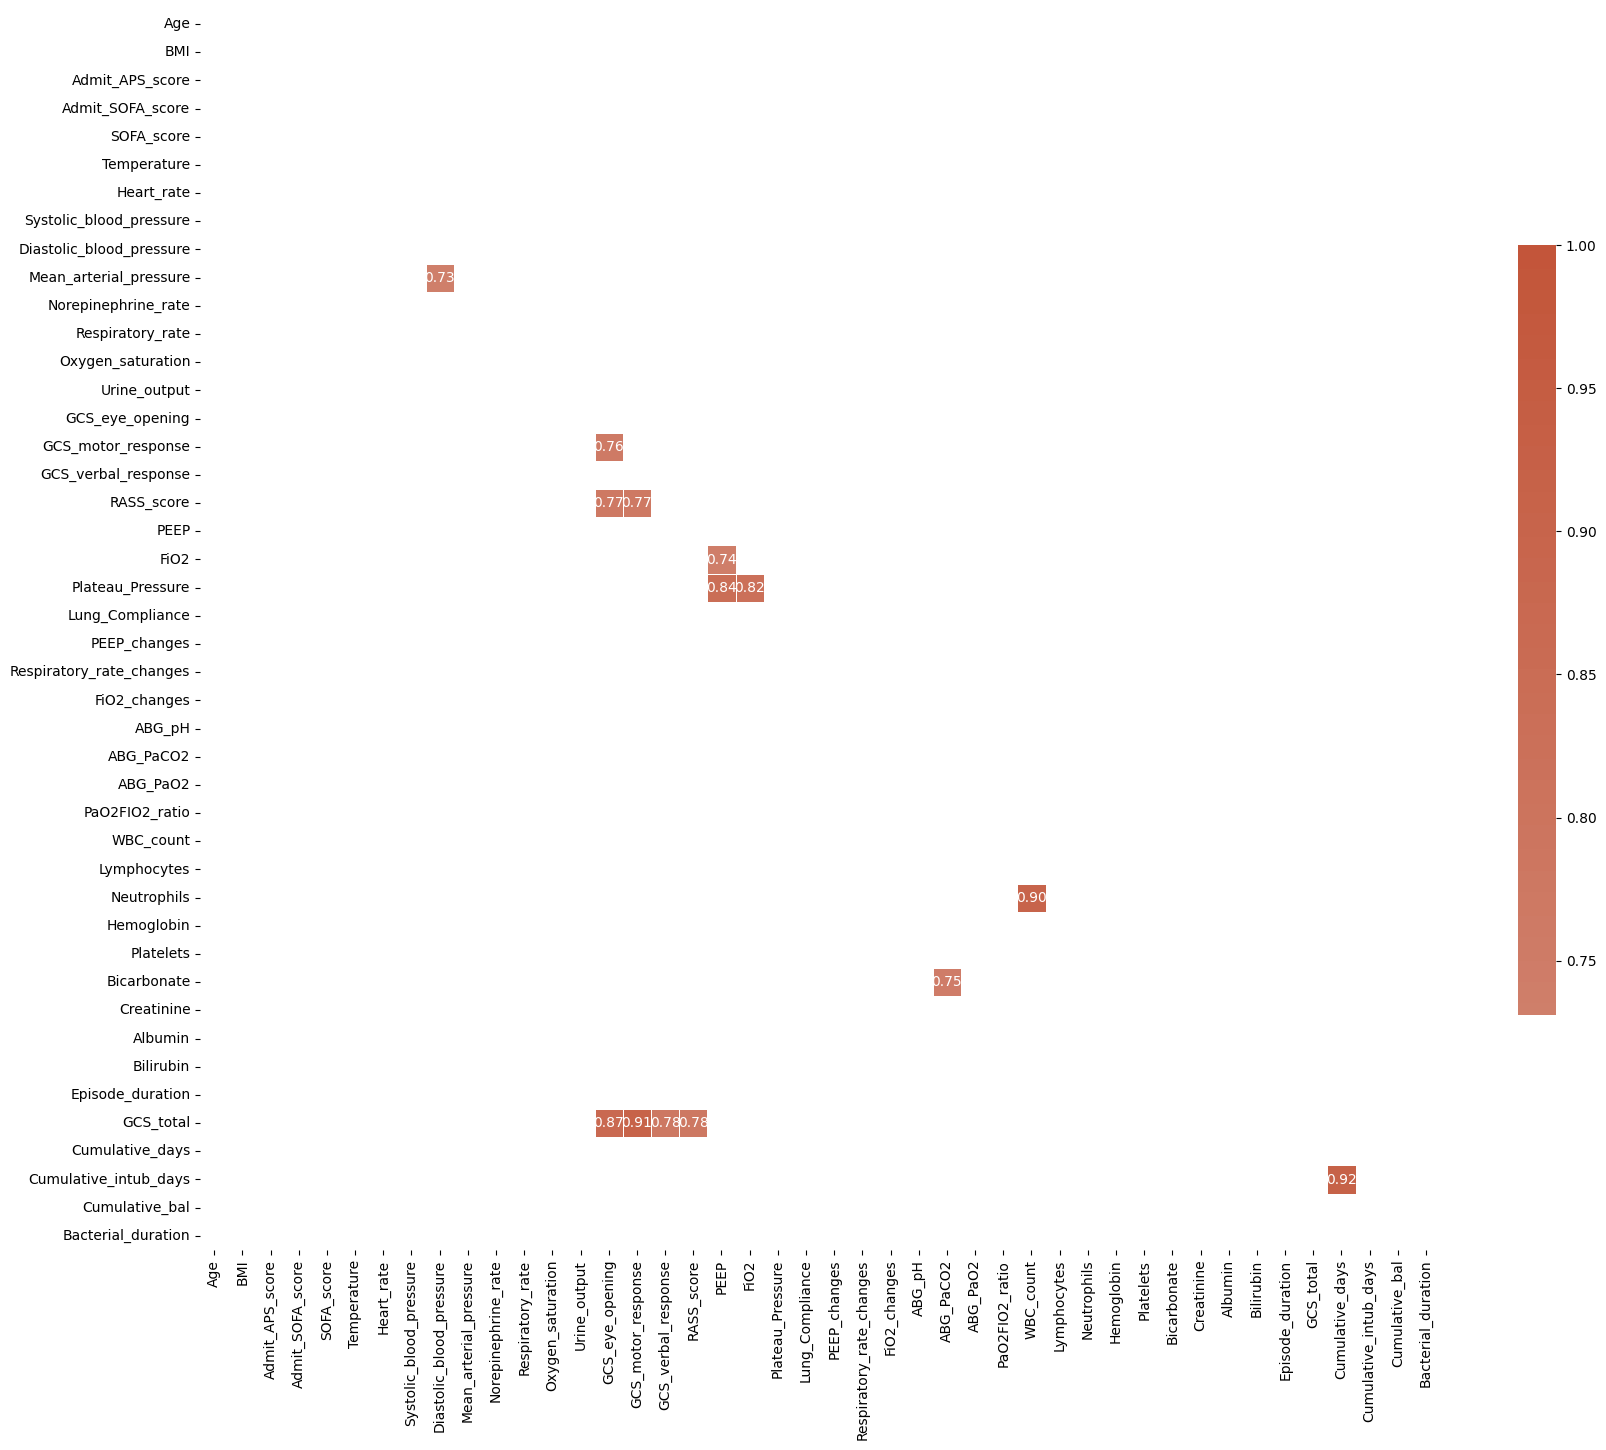

In [46]:
numeric_columns  = ['Age', 'BMI', 'Admit_APS_score', 'Admit_SOFA_score', 'SOFA_score',
                    'Temperature', 'Heart_rate', 'Systolic_blood_pressure', 'Diastolic_blood_pressure', 'Mean_arterial_pressure',
                    'Norepinephrine_rate', 'Respiratory_rate', 'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
                    'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP', 'FiO2', 'Plateau_Pressure', 'Lung_Compliance',
                    'PEEP_changes', 'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
                    'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
                    'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
                    'Bilirubin', 'Episode_duration','GCS_total', 'Cumulative_days','Cumulative_intub_days', 'Cumulative_bal', 'Bacterial_duration']

correlation_matrix = dataset_df[numeric_columns].corr()
filtered_corr = correlation_matrix[abs(correlation_matrix) > 0.72]

mask = np.triu(np.ones_like(filtered_corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(filtered_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f")
plt.show()

### Correlation between 'WBC_count' and 'Neutrophils'
These two features are highly correlated; we choose to keep only the variable 'WBC_count' since it has less null values than 'Neutrophils'.

             WBC_count  Neutrophils
WBC_count     1.000000     0.903878
Neutrophils   0.903878     1.000000


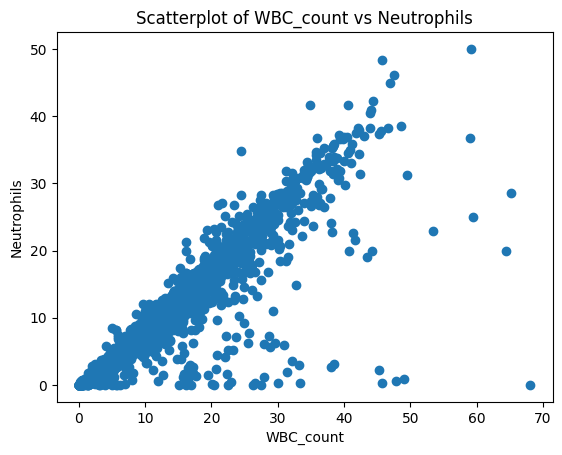

In [47]:
print(dataset_df[['WBC_count','Neutrophils']].corr())

plt.scatter(dataset_df['WBC_count'], dataset_df['Neutrophils'])
plt.title('Scatterplot of WBC_count vs Neutrophils')
plt.xlabel('WBC_count')
plt.ylabel('Neutrophils')

dataset_df.drop(['Neutrophils'], axis=1, inplace=True)

### Correlation between 'RASS_score', 'GCS_total', 'GCS_eye_opening', 'GCS_motor_response' and 'GCS_verbal_response'
These features are all highly correlated, we choose to keep only the variable 'GCS_total'.

In [48]:
print(dataset_df[['RASS_score','GCS_total','GCS_eye_opening','GCS_motor_response','GCS_verbal_response']].corr())

dataset_df.drop(['RASS_score','GCS_eye_opening','GCS_motor_response','GCS_verbal_response'], axis=1, inplace=True)

                     RASS_score  GCS_total  GCS_eye_opening  \
RASS_score             1.000000   0.781100         0.773453   
GCS_total              0.781100   1.000000         0.871789   
GCS_eye_opening        0.773453   0.871789         1.000000   
GCS_motor_response     0.773453   0.911088         0.760648   
GCS_verbal_response    0.485963   0.778712         0.529959   

                     GCS_motor_response  GCS_verbal_response  
RASS_score                     0.773453             0.485963  
GCS_total                      0.911088             0.778712  
GCS_eye_opening                0.760648             0.529959  
GCS_motor_response             1.000000             0.507270  
GCS_verbal_response            0.507270             1.000000  


### Correlation between 'Bicarbonate' and 'ABG_PaCO2'
These two features are highly correlated; we choose to keep only the variable 'Bicarbonate' since it has less null values than 'ABG_PaCO2'.

             Bicarbonate  ABG_PaCO2
Bicarbonate     1.000000   0.747441
ABG_PaCO2       0.747441   1.000000


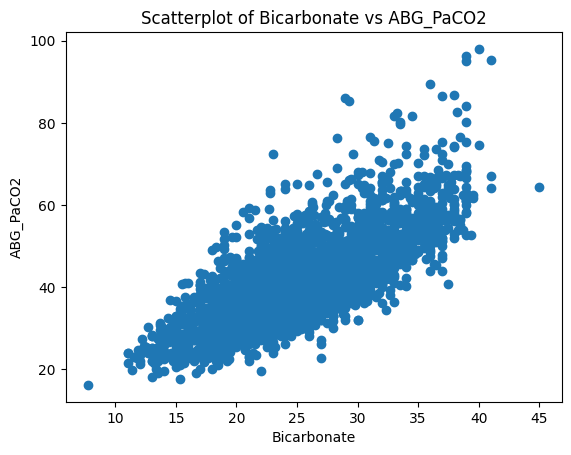

In [49]:
print(dataset_df[['Bicarbonate','ABG_PaCO2']].corr())

plt.scatter(dataset_df['Bicarbonate'], dataset_df['ABG_PaCO2'])
plt.title('Scatterplot of Bicarbonate vs ABG_PaCO2')
plt.xlabel('Bicarbonate')
plt.ylabel('ABG_PaCO2')

dataset_df.drop(['ABG_PaCO2'], axis=1, inplace=True)

### Correlation between 'Diastolic_blood_pressure' and 'Mean_arterial_pressure'
These two features are highly correlated; we choose to keep only the variable 'Diastolic_blood_pressure' since it has less null values than 'Mean_arterial_pressure'.

                          Diastolic_blood_pressure  Mean_arterial_pressure
Diastolic_blood_pressure                  1.000000                0.731073
Mean_arterial_pressure                    0.731073                1.000000


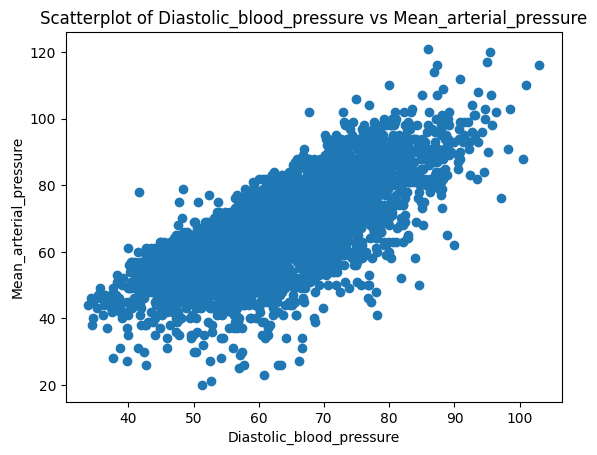

In [50]:
print(dataset_df[['Diastolic_blood_pressure','Mean_arterial_pressure']].corr())

plt.scatter(dataset_df['Diastolic_blood_pressure'], dataset_df['Mean_arterial_pressure'])
plt.title('Scatterplot of Diastolic_blood_pressure vs Mean_arterial_pressure')
plt.xlabel('Diastolic_blood_pressure')
plt.ylabel('Mean_arterial_pressure')

dataset_df.drop(['Mean_arterial_pressure'], axis=1, inplace=True)

### Correlation among 'PEEP', 'FiO2', 'Plateau_Pressure'
These three features are highly correlated; we choose to keep only the variable 'FiO2' since it has less null values than others.

                      PEEP      FiO2  Plateau_Pressure
PEEP              1.000000  0.738116          0.840004
FiO2              0.738116  1.000000          0.824783
Plateau_Pressure  0.840004  0.824783          1.000000


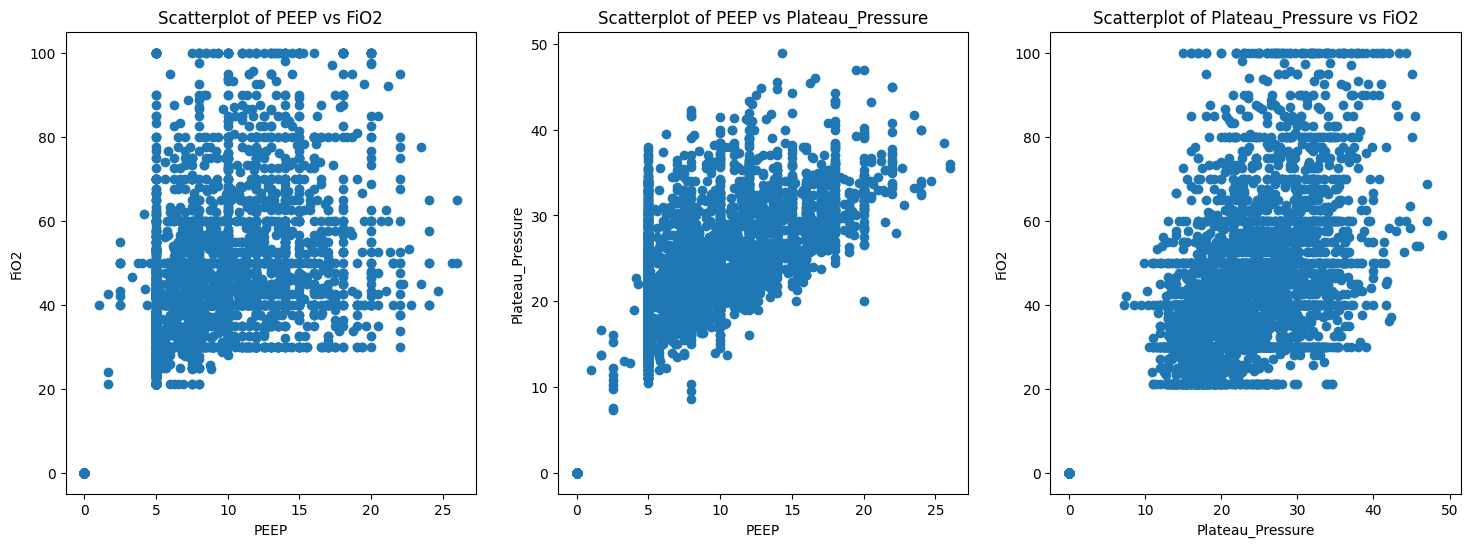

In [51]:
print(dataset_df[['PEEP','FiO2','Plateau_Pressure']].corr())

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,6))

axes[0].scatter(dataset_df['PEEP'], dataset_df['FiO2'])
axes[0].set_title('Scatterplot of PEEP vs FiO2')
axes[0].set_xlabel('PEEP')
axes[0].set_ylabel('FiO2')

axes[1].scatter(dataset_df['PEEP'], dataset_df['Plateau_Pressure'])
axes[1].set_title('Scatterplot of PEEP vs Plateau_Pressure')
axes[1].set_xlabel('PEEP')
axes[1].set_ylabel('Plateau_Pressure')

axes[2].scatter(dataset_df['Plateau_Pressure'], dataset_df['FiO2'])
axes[2].set_title('Scatterplot of Plateau_Pressure vs FiO2')
axes[2].set_xlabel('Plateau_Pressure')
axes[2].set_ylabel('FiO2')


dataset_df.drop(['Plateau_Pressure', 'PEEP'], axis=1, inplace=True)

### Correlation among 'Cumulative_days' and 'Cumulative_intub_days'
These features are highly correlated; we choose to keep only the variable 'Cumulative_intub_days' since we think it is more relevant for analysis on pneumonia.

                       Cumulative_days  Cumulative_intub_days
Cumulative_days               1.000000               0.915462
Cumulative_intub_days         0.915462               1.000000


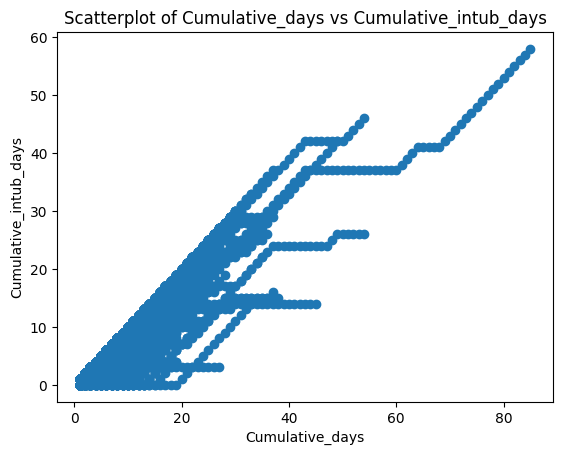

In [52]:
print(dataset_df[['Cumulative_days','Cumulative_intub_days']].corr())

plt.scatter(dataset_df['Cumulative_days'], dataset_df['Cumulative_intub_days'])
plt.title('Scatterplot of Cumulative_days vs Cumulative_intub_days')
plt.xlabel('Cumulative_days')
plt.ylabel('Cumulative_intub_days')

dataset_df.drop(['Cumulative_days'], axis=1, inplace=True)

# Check variables' ranges
We want to check the range of variables, to eventually discard observations incorrectly registered and so clinically meaningless. 

In [53]:
dataset_df.describe()

,Patient_id,External_transfer_flag,Binary_outcome,Age,BMI,Admit_APS_score,Admit_SOFA_score,Tracheostomy_flag,ICU_stay,ICU_day,SOFA_score,ECMO_flag,Intubation_flag,Hemodialysis_flag,CRRT_flag,Temperature,Heart_rate,Systolic_blood_pressure,Diastolic_blood_pressure,Norepinephrine_rate,Norepinephrine_flag,Respiratory_rate,Oxygen_saturation,Urine_output,FiO2,Lung_Compliance,PEEP_changes,Respiratory_rate_changes,FiO2_changes,ABG_pH,ABG_PaO2,PaO2FIO2_ratio,WBC_count,Lymphocytes,Hemoglobin,Platelets,Bicarbonate,Creatinine,Albumin,Bilirubin,Episode_duration,GCS_total,Next_day_outcome,Cumulative_intub_days,Cumulative_bal,Bacterial_duration
count,6023.000000,6023.000000,6023.00000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000,6021.000000,6022.000000,6022.000000,6022.000000,6023.000000,6023.000000,5994.000000,6020.000000,5135.000000,5888.000000,5467.000000,5895.000000,5895.000000,5895.000000,3433.000000,3432.000000,3979.000000,5945.000000,3877.000000,5890.000000,5984.000000,5945.000000,5930.000000,4716.000000,4597.000000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000,6023.000000
mean,4650.982401,0.311141,0.48099,60.989374,30.165672,86.289391,10.430184,0.250374,1.250872,8.663125,8.868338,0.052466,0.787149,0.044994,0.149095,98.704752,87.712543,119.989792,60.945176,0.049879,0.376723,22.889255,96.403016,1302.421130,34.145232,24.483689,1.282952,1.589313,1.485327,7.396370,95.618886,196.017190,12.390169,1.038392,9.131497,195.017881,25.709509,1.525964,2.761209,1.523209,4.029719,8.450772,0.030882,8.749128,0.859372,1.604018
std,2952.949074,0.462999,0.49968,11.885296,7.718569,32.546302,4.446187,0.433264,0.613954,6.553506,4.739942,0.222982,0.409357,0.207309,0.356212,1.149319,16.910356,17.254345,10.127405,0.094370,0.484605,5.430116,2.230983,1107.048588,23.249440,18.131424,1.109086,1.430598,1.242588,0.074532,30.764576,100.246399,8.254975,0.816449,1.803192,134.282667,5.366147,1.265340,0.539845,2.122215,5.209457,4.328644,0.173011,7.889345,0.606328,3.222476
min,43.000000,0.000000,0.00000,30.000000,12.460000,23.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.180000,41.625000,69.227273,33.866667,0.000000,0.000000,1.000000,75.888889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.920000,32.000000,3.000000,0.100000,0.000000,5.000000,1.000000,7.750000,0.200000,1.500000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,0.000000,0.00000,53.000000,25.130000,63.000000,8.000000,0.000000,1.000000,3.000000,5.000000,0.000000,1.000000,0.000000,0.000000,98.050000,75.158854,107.500000,53.951389,0.000000,0.000000,18.948026,94.920000,443.500000,22.158730,6.058333,1.000000,1.000000,1.000000,7.350000,76.108333,123.640000,7.300000,0.400000,7.750000,85.000000,22.250000,0.680000,2.400000,0.500000,0.000000,4.000000,0.000000,3.000000,0.000000,0.000000
50%,4361.000000,0.000000,0.00000,62.000000,29.680000,88.000000,10.000000,0.000000,1.000000,7.000000,9.000000,0.000000,1.000000,0.000000,0.000000,98.600000,86.506757,117.268468,59.710801,0.000000,0.000000,22.311422,96.545933,1062.000000,35.000000,26.000000,1.000000,1.000000,1.000000,7.404000,88.666667,174.730000,10.700000,0.900000,8.600000,179.000000,25.333333,1.090000,2.700000,0.700000,0.000000,9.000000,0.000000,7.000000,1.000000,0.000000
75%,7208.000000,1.000000,1.00000,71.000000,34.690000,109.000000,13.000000,1.000000,1.000000,13.000000,12.000000,0.000000,1.000000,0.000000,0.000000,99.333333,99.290179,130.374668,67.048611,0.062610,1.000000,26.291331,98.153846,1940.000000,46.666667,37.250000,2.000000,2.000000,2.000000,7.450000,107.762500,250.000000,15.400000,1.400000,10.200000,280.000000,29.000000,1.900000,3.100000,1.400000,7.000000,11.000000,0.000000,13.000000,1.000000,2.000000
max,9997.000000,1.000000,1.00000,80.000000,55.750000,183.000000,23.000000,1.000000,6.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,104.025000,152.87500

### Analysis of 'Respiratory_rate' values
We check the range of values of 'Respiratory_rate' and see that there's a patient with a recorded value of 'Respiratory_rate' lower than 5, in particular 1. We think that this value has no sense, maybe it has been reported wrongly, so we decide to remove the corresponding row from the dataset.

      Patient_id  Respiratory_rate
4423        7038               1.0


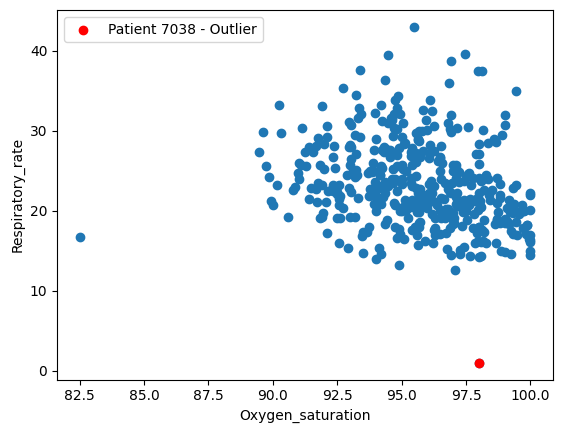

In [54]:
print(dataset_df.loc[dataset_df['Respiratory_rate'] < 5, ['Patient_id', 'Respiratory_rate']])

plt.scatter(dataset_df['Oxygen_saturation'].groupby(dataset_df['Patient_id'], group_keys=True).first(),
            dataset_df['Respiratory_rate'].groupby(dataset_df['Patient_id'], group_keys=True).first())
plt.scatter(dataset_df.loc[4423, 'Oxygen_saturation'], dataset_df.loc[4423, 'Respiratory_rate'],
            color='red', label='Patient 7038 - Outlier')
plt.xlabel('Oxygen_saturation')
plt.ylabel('Respiratory_rate')
plt.legend()
plt.show()

#Remove this row from the dataset
dataset_df = dataset_df[(dataset_df['Patient_id']!= 7038) & (dataset_df['Respiratory_rate']>5)]
dataset_df = dataset_df.reset_index(drop=True)

# Split Train-Test sets
We first use the OneHotEncoder to encode the categorical variables and then split the dataset into training and test sets, stratifying them with respect to the target variable 'Next_day_outcome' in order to keep the same proportion of the classes.

In [55]:
dataset_df.replace({pd.NA: np.nan}, inplace=True)

In [56]:
# One-Hot Encoding of the categorical variables in the dataset
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
encoded_columns = onehot_encoder.fit_transform(dataset_df[['Admission_source_name','Patient_category','COVID_status','Ethnicity',
                                                           'Gender','Race','Smoking_status', 'Episode_category','Episode_etiology']].astype(str))
encoded_df = pd.DataFrame(encoded_columns, 
                          columns=onehot_encoder.get_feature_names_out(['Admission_source_name','Patient_category','COVID_status','Ethnicity',
                                                                        'Gender','Race','Smoking_status', 'Episode_category','Episode_etiology']))
 
# Concatenate encoded columns with original dataset
dataset_df = pd.concat([dataset_df, encoded_df], axis=1)

# Drop old categorical variables
dataset_df.drop(['Admission_source_name','Patient_category','COVID_status','Ethnicity','Gender','Race','Smoking_status', 
                 'Episode_category','Episode_etiology'], axis=1, inplace=True)


We can see that the classification problem is very imbalanced since the class related to died patients represents just the 3% of total observations. So in the further steps we need to take into account this situation and introduce some weigths in order to enforce the model to predict correctly also the minority class.

In [57]:
dataset_df['Next_day_outcome'].value_counts() / dataset_df.shape[0]

Next_day_outcome
0    0.969205
1    0.030795
Name: count, dtype: float64

In [58]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset_df, dataset_df['Next_day_outcome'], test_size=0.2, 
                                                    random_state=42, stratify=dataset_df['Next_day_outcome'])

# Save a copy that might be useful later
info_train = X_train
info_test = X_test

# Remove features that are useless for the model
X_train.drop(['Patient_id/ICU_stay/ICU_day', 'Patient_id', 'Binary_outcome', 'Next_day_outcome', 'Discharge_disposition'], axis=1, inplace=True)
X_test.drop(['Patient_id/ICU_stay/ICU_day', 'Patient_id', 'Binary_outcome', 'Next_day_outcome', 'Discharge_disposition'], axis=1, inplace=True)

print('Dimension of the training set:', X_train.shape)
print('Dimension of the test set:', X_test.shape)

Dimension of the training set: (4780, 79)
Dimension of the test set: (1195, 79)


# Imputation of values
We use a KNN Imputer in order to substitute the remaining null values, choosing the best number of neighbours through 5-Fold Cross Validation.

In [59]:
# Look at the percentage of cells wtih null values to set an appropriate missing rate in next function
num_null = X_train.isnull().sum()
total_null = num_null[20:38].sum()
total_null/(X_train.shape[0]*18)

0.13349604834960482

In [61]:
# In order to evaluate the error of the KNN imputer on the dataset, we create a function that masks some known values fixing some missing rate,
# impute these values and compute the MSE between the real and the imputed values.
def mask_data(df, columns, missing_rate=0.2):
    np.random.seed(42)
    df_missing = df.copy()
    missing_indices = {col: [] for col in columns}
    for col in columns:
        n_samples = df.shape[0]
        n_missing = int(n_samples * missing_rate)
        valid_indices = df[df[col].notna()].index         
        missing_samples = np.random.choice(valid_indices, n_missing, replace=False, )
        df_missing.loc[missing_samples, col] = np.nan
        missing_indices[col] = missing_samples

    return df_missing, missing_indices

def cross_val_imputer(df, columns, param_grid, cv=5, missing_rate=0.15):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    errors = {k: [] for k in param_grid['n_neighbors']}
    for train_index, test_index in kf.split(df):
        df_train, df_valid = df.iloc[train_index], df.iloc[test_index]
        # Mask data in the training and validation sets
        df_train_missing, train_missing_indices = mask_data(df_train, columns, missing_rate)
        df_valid_missing, valid_missing_indices = mask_data(df_valid, columns, missing_rate)
        for k in param_grid['n_neighbors']:
            knn_imputer = KNNImputer(n_neighbors=k)
            df_train_imputed = knn_imputer.fit_transform(df_train_missing)
            df_valid_imputed = knn_imputer.transform(df_valid_missing)
            # Compute the error only on artificially masked values of the validation set
            valid_errors = []
            for col in columns:
                true_values = df_valid.loc[valid_missing_indices[col], col]
                imputed_values = df_valid_imputed[df_valid_missing.index.get_indexer(valid_missing_indices[col]), df.columns.get_loc(col)]
                valid_errors.append(mean_squared_error(true_values, imputed_values))
            errors[k].append(np.mean(valid_errors))
    avg_errors = {k: np.mean(errors[k]) for k in errors}
    best_k = min(avg_errors, key=avg_errors.get)
    
    return best_k, avg_errors

In [63]:
# Param grid for searching optimal number of neighbors
param_grid = {'n_neighbors': list(range(10, 12))}

X_train_reset = X_train.reset_index(drop=True)
columns_to_mask = X_train_reset.columns[21:38]

best_k, avg_errors = cross_val_imputer(X_train_reset, columns_to_mask, param_grid)
print(f'The best value of k is: {best_k}')

The best value of k is: 11


In [62]:
# Initialization of KNNImputer
knn_imputer = KNNImputer(n_neighbors=best_k, weights='distance')

# Imputation of missing values in the training set
data_knn_imputed = knn_imputer.fit_transform(X_train)
X_train_imputed = pd.DataFrame(data_knn_imputed, columns=X_train.columns)

# Imputation of missing values in the test set, using the same KNNImputer
data_knn_imputed = knn_imputer.transform(X_test)
X_test_imputed = pd.DataFrame(data_knn_imputed, columns=X_test.columns)

Standardize numerical data, from both training and test sets

In [63]:
scaler=StandardScaler()

numeric_columns = ['Age', 'BMI', 'Admit_APS_score','Admit_SOFA_score', 'ICU_stay','ICU_day','SOFA_score', 'Temperature', 'Heart_rate', 
                   'Systolic_blood_pressure','Diastolic_blood_pressure', 'Norepinephrine_rate','Respiratory_rate', 'Oxygen_saturation',
                   'Urine_output', 'FiO2','Lung_Compliance', 'PEEP_changes', 'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH',
                   'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Hemoglobin','Platelets', 'Bicarbonate', 'Creatinine', 
                   'Albumin', 'Bilirubin','Episode_duration','GCS_total','Cumulative_intub_days','Cumulative_bal','Bacterial_duration']

X_train_scaled_num=scaler.fit_transform(X_train_imputed[numeric_columns])

X_train_scaled=X_train_imputed
X_train_scaled[numeric_columns]=X_train_scaled_num

In [64]:
X_test_scaled_num=scaler.transform(X_test_imputed[numeric_columns])

X_test_scaled = X_test_imputed
X_test_scaled[numeric_columns]=X_test_scaled_num

# Classification Models

In [65]:
# Parameter for the K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Logistic Regression

### GridSearch for Parameter Selection of Logistic_Regression
We implement a GridSearch algorithm to select the best parameters for the Logistic Regression by maximizing the balanced accuracy.

In [66]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced', solver='liblinear')
}

param_grids = {
    "Logistic Regression": {"C": [0.001, 0.01, 0.1, 0.5, 1], 'penalty':['l2','l1']}
}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        scoring='balanced_accuracy',
        cv=cv,
    ).fit(X_train_scaled, y_train)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

In [ ]:
for result in results:
    print(f"Model: {result['model']}")
    cv_results = result['cv_results']
        
    best_index = cv_results['mean_test_score'].idxmax()
    best_param = cv_results.loc[best_index, 'params']
    print(f"Best parameters: {best_param}")
    print(f"Best CV score: {cv_results.loc[best_index, 'mean_test_score']}\n")

In [ ]:
# Fitting the Logistic Regression with the best selected parameters
log_reg = LogisticRegression(penalty=best_param['penalty'], random_state=42, C=best_param['C'], max_iter=10000, 
                             class_weight='balanced',solver='liblinear')
log_reg.fit(X_train_scaled, y_train) 

scores = cross_validate(log_reg, X_train_scaled, y_train, cv=kf, scoring=('balanced_accuracy','f1','precision','recall','accuracy'))
print('Accuracy:',np.mean(scores['test_accuracy']))
print('Balanced_accuracy:',np.mean(scores['test_balanced_accuracy']))
print('F1_score:',np.mean(scores['test_f1']))
print('Precision:',np.mean(scores['test_precision']))
print('Recall:',np.mean(scores['test_recall']))

In [ ]:
# Compute the normalized confusion matrix of the Logistic Regression of the Cross Validation
y_train_pred = cross_val_predict(log_reg, X_train_scaled, y_train, cv=kf)

cm_log_reg =confusion_matrix(y_train, y_train_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm_log_reg,display_labels=log_reg.classes_)
disp.plot(cmap='Blues')

## SGD Classifier

### GridSearch for Parameter Selection of SGD_Classifier
We implement a GridSearch algorithm to select the best parameters for the SGD_Classifier by maximizing the balanced accuracy.

In [70]:
models = {
    "SGD Classifier": SGDClassifier(random_state=42, penalty='l2', max_iter=100000, class_weight='balanced', n_jobs=-1,
                                    early_stopping=True, validation_fraction=0.2)
}

param_grids = {
    "SGD Classifier": {'alpha' : np.arange(0.5,1.5,0.05), 'loss' : ['hinge', 'squared_hinge','perceptron']}
}

cv = KFold(n_splits=4, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        scoring='balanced_accuracy',
        cv=cv,
    ).fit(X_train_scaled, y_train)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)


In [ ]:
for result in results:
    print(f"Model: {result['model']}")
    cv_results = result['cv_results']
        
    best_index = cv_results['mean_test_score'].idxmax()
    best_param = cv_results.loc[best_index, 'params']
    print(f"Best parameters: {best_param}")
    print(f"Best CV score: {cv_results.loc[best_index, 'mean_test_score']}\n")

In [ ]:
# Fitting the SGD_classifier with the best selected parameters
sgd_reg=SGDClassifier(alpha=best_param['alpha'], loss=best_param['loss'],penalty='l2', random_state=42, max_iter=100000,
                      class_weight='balanced', n_jobs=-1, early_stopping=True, validation_fraction=0.2) 
sgd_reg.fit(X_train_scaled,y_train)  

scores = cross_validate(sgd_reg, X_train_scaled, y_train, cv=kf, scoring=('balanced_accuracy','f1','precision','recall','accuracy'))
print('Accuracy:',np.mean(scores['test_accuracy']))
print('Balanced_accuracy:',np.mean(scores['test_balanced_accuracy']))
print('F1_score:',np.mean(scores['test_f1']))
print('Precision:',np.mean(scores['test_precision']))
print('Recall:',np.mean(scores['test_recall']))

In [ ]:
# Compute the normalized confusion matrix of the SGD_classifier of the Cross Validation
y_train_pred = cross_val_predict(sgd_reg, X_train_scaled, y_train, cv=kf)

cm_sgd_reg =confusion_matrix(y_train, y_train_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm_sgd_reg,display_labels=sgd_reg.classes_)
disp.plot(cmap='Blues')

## Support Vector Machine Classifier

### GridSearch for Parameter Selection of SVC
We implement a GridSearch algorithm to select the best parameters for the SVC by maximizing the balanced accuracy.

In [74]:
models = {
    "SVC": SVC(random_state=42, class_weight='balanced')
}

param_grids = {
    "SVC": {"C": (0.01, 0.1, 0.2), 'kernel': ['linear', 'poly', 'rbf'], 'degree':(3,4)}
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        scoring='balanced_accuracy',
        cv=cv,
    ).fit(X_train_scaled, y_train)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

In [ ]:
for result in results:
    print(f"Model: {result['model']}")
    cv_results = result['cv_results']
        
    best_index = cv_results['mean_test_score'].idxmax()
    best_param = cv_results.loc[best_index, 'params']
    print(f"Best parameters: {best_param}")
    print(f"Best CV score: {cv_results.loc[best_index, 'mean_test_score']}\n")

In [ ]:
# Fitting the SVC with the best selected parameters
svm_class=SVC(C=best_param['C'], kernel=best_param['kernel'], random_state=42, class_weight='balanced') 
svm_class.fit(X_train_scaled,y_train)    

scores = cross_validate(svm_class, X_train_scaled, y_train, cv=kf, scoring=('balanced_accuracy','f1','precision','recall','accuracy'))
print('Accuracy:',np.mean(scores['test_accuracy']))
print('Balanced_accuracy:',np.mean(scores['test_balanced_accuracy']))
print('F1_score:',np.mean(scores['test_f1']))
print('Precision:',np.mean(scores['test_precision']))
print('Recall:',np.mean(scores['test_recall']))

In [ ]:
# Compute the normalized confusion matrix of the SVC of the Cross Validation
y_train_pred = cross_val_predict(svm_class, X_train_scaled, y_train, cv=kf)

norm_CM_svm_class =confusion_matrix(y_train, y_train_pred, normalize='true')  #normalized with respect to the observations (%)
disp = ConfusionMatrixDisplay(norm_CM_svm_class, display_labels=svm_class.classes_)
disp.plot(cmap='Blues')

## Random Forest

### SMOTE

In [78]:
from imblearn.over_sampling import SMOTE

In [79]:
desired_ratio = 0.2
smote = SMOTE(random_state=42, sampling_strategy = desired_ratio)
 
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)


In [80]:
# We check if the resampled observations obtained with SMOTE are clinically consistent

def check_SMOTE(df):
    for i in range(len(df)):
        if (df.loc[i, 'Intubation_flag'] == 0) & (df.loc[i, 'FiO2_changes']>1e-5):
            print(df.loc[i, ['Patient_id']])

        if (df.loc[i, 'Intubation_flag'] == 0) & (df.loc[i,'Respiratory_rate_changes']>1e-5):
            print(df.loc[i, ['Patient_id']])

        if (df.loc[i, 'Intubation_flag'] == 0) & (df.loc[i,'PEEP_changes']>1e-5):
            print(df.loc[i, ['Patient_id']])
        
        if (df.loc[i, 'Intubation_flag'] == 0) & (df.loc[i,'Lung_Compliance']>1e-5):
            print(df.loc[i, ['Patient_id']])

        if (df.loc[i, 'Intubation_flag'] == 0) & (df.loc[i,'FiO2']>1e-5):
            print(df.loc[i, ['Patient_id']])

        if (df.loc[i, 'Norepinephrine_flag'] == 0) & (df.loc[i,'Norepinephrine_rate']>1e-5):
            print(df.loc[i, ['Patient_id']])

        if df.loc[i,['Admission_source_name_Emergency Room','Admission_source_name_From Community','Admission_source_name_From Home/Work',
                'Admission_source_name_Hospital OP Dept/Amb Surgery Center','Admission_source_name_Information Unavailable',
                'Admission_source_name_Internal Transfer','Admission_source_name_Other Healthcare Facility','Admission_source_name_Outpatient Testing',
                'Admission_source_name_Outside Hospital','Admission_source_name_Rehab Facility (RIC)','Admission_source_name_Skilled Nursing Facility',
                'Admission_source_name_Transfer from Acute Hospital']].sum() > 1:
            print(df.loc[i, ['Patient_id']])

        if df.loc[i,['Patient_category_Non-Pneumonia Control','Patient_category_Other Pneumonia','Patient_category_Other Viral Pneumonia']].sum() > 1:
            print(df.loc[i, ['Patient_id']])

        if df.loc[i,['Ethnicity_Not Hispanic or Latino', 'Ethnicity_Unknown or Not Reported']].sum() > 1:
            print(df.loc[i, ['Patient_id']])

        if df.loc[i,['Race_Black or African American','Race_Unknown or Not Reported', 'Race_White']].sum() > 1:
            print(df.loc[i, ['Patient_id']])

        if df.loc[i,['Smoking_status_Never Smoker', 'Smoking_status_Past Smoker','Smoking_status_Unknown Smoking Status']].sum() > 1:
            print(df.loc[i, ['Patient_id']])

        if df.loc[i,['Episode_category_CAP','Episode_category_HAP', 'Episode_category_Non-PNA-ctrl','Episode_category_VAP']].sum() > 1:
            print(df.loc[i, ['Patient_id']])

        if df.loc[i,['Episode_etiology_Bacterial/viral','Episode_etiology_Before-first-bal','Episode_etiology_Culture-negative', 
                'Episode_etiology_Indeterminate','Episode_etiology_Non-PNA-ctrl', 'Episode_etiology_Viral']].sum() > 1:
            print(df.loc[i, ['Patient_id']])
        

check_SMOTE(X_train_resampled)

#### Grid Search for Parameter Selection of Random Forest + SMOTE

In [ ]:
rnd_clf_smote = RandomForestClassifier(n_estimators=200, random_state=42, max_features=40, n_jobs=-1, class_weight = 'balanced')

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500] 
}

scoring = {
    'accuracy': 'accuracy',
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

grid_search = GridSearchCV(estimator=rnd_clf_smote, param_grid=param_grid, cv=kf, scoring=scoring, refit='balanced_accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameter found:")
print(grid_search.best_params_)
print("Best balanced accuracy score found:", grid_search.best_score_)

In [ ]:
# Fitting the RandomForestClassifier with the best selected parameters
rnd_clf_smote = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], random_state=42, max_features=40, n_jobs=-1, class_weight = 'balanced')
rnd_clf_smote.fit(X_train_resampled, y_train_resampled)

scores = cross_validate(rnd_clf_smote, X_train_resampled, y_train_resampled, cv=kf, scoring=('f1','precision','recall','balanced_accuracy','accuracy'))
 
print('Accuracy:',np.mean(scores['test_accuracy']))
print('Balanced_accuracy:',np.mean(scores['test_balanced_accuracy']))
print('F1_score:',np.mean(scores['test_f1']))
print('Precision:',np.mean(scores['test_precision']))
print('Recall:',np.mean(scores['test_recall']))

In [ ]:
# Compute the normalized confusion matrix of the RandomForestClassifier of the Cross Validation
y_train_pred_smote = cross_val_predict(rnd_clf_smote, X_train_resampled, y_train_resampled, cv=kf)

cm_smote =confusion_matrix(y_train_resampled, y_train_pred_smote, normalize='true')
disp = ConfusionMatrixDisplay(cm_smote,display_labels=rnd_clf_smote.classes_)
disp.plot(cmap='Blues')

#### Evaluation on the test set

In [ ]:
y_pred_rf = rnd_clf_smote.predict(X_test_imputed)

print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Balanced_accuracy:', balanced_accuracy_score(y_test, y_pred_rf))
print('F1_score:', f1_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('AUC:', roc_auc_score(y_test, y_pred_rf))

cm_log =confusion_matrix(y_test, y_pred_rf, normalize='true')
disp = ConfusionMatrixDisplay(cm_log, display_labels=rnd_clf_smote.classes_)
disp.plot(cmap='Blues')
plt.title(f'Confusion matrix of SMOTE+RandomForest using test set')


# Comparison of the models

In [ ]:
#prediction of the scores
y_scores = cross_val_predict(log_reg, X_train_scaled, y_train, cv=kf, method='decision_function') 
precisions,recalls, thresholds=precision_recall_curve(y_train,y_scores)

y_scores1 = cross_val_predict(sgd_reg, X_train_scaled, y_train, cv=kf, method='decision_function') 
precisions1,recalls1, thresholds1=precision_recall_curve(y_train,y_scores1)

y_scores2 = cross_val_predict(svm_class, X_train_scaled, y_train, cv=kf, method='decision_function') 
precisions2,recalls2, thresholds2=precision_recall_curve(y_train,y_scores2)

#Plot the Precision-Recall graph
plt.rc('figure', figsize=(8, 8))
plt.plot(recalls, precisions, "b-", linewidth=2, label='logistic')
plt.plot(recalls1, precisions1, "r-", linewidth=2, label='sgd')
plt.plot(recalls2, precisions2, "g-", linewidth=2, label='svc')
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend()


In [ ]:
#ROC curve
fpr,tpr,thresholds = roc_curve(y_train,y_scores)
fpr1,tpr1,thresholds1 = roc_curve(y_train,y_scores1)
fpr2,tpr2,thresholds2 = roc_curve(y_train,y_scores2)

plt.plot(fpr,tpr, "b-", linewidth=2, label='logistic')
plt.plot(fpr1,tpr1, "r-", linewidth=2, label='sgd')
plt.plot(fpr2,tpr2, "g-", linewidth=2, label='svc')
plt.xlabel("false positive rate", fontsize=16)
plt.ylabel("True positive rate (recall)", fontsize=16)
plt.plot([0,1],[0,1],'k--')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend()

In [ ]:
# Compute the AUC coefficient for each classifier
print('AUC of Logistic Regression:',roc_auc_score(y_train, y_scores))
print('AUC of SGD_Classifier:',roc_auc_score(y_train, y_scores1))
print('AUC of SVC:',roc_auc_score(y_train, y_scores2))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,6))

# logistic regression
y_test_pred = log_reg.predict(X_test_scaled)
cm_log =confusion_matrix(y_test, y_test_pred, normalize='true')  #normalized with respect to the observations (%)
disp = ConfusionMatrixDisplay(cm_log, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', ax=axes[0])
axes[0].set_title(f'Confusion matrix from Logistic regression')

# sgd
y_test_pred = sgd_reg.predict(X_test_scaled)
cm_sgd =confusion_matrix(y_test, y_test_pred, normalize='true')  #normalized with respect to the observations (%)
disp = ConfusionMatrixDisplay(cm_sgd, display_labels=sgd_reg.classes_)
disp.plot(cmap='Blues', ax=axes[1])
axes[1].set_title(f'Confusion matrix from SGD')

# svm
y_test_pred = svm_class.predict(X_test_scaled)
cm_svm =confusion_matrix(y_test, y_test_pred, normalize='true')  #normalized with respect to the observations (%)
disp = ConfusionMatrixDisplay(cm_svm, display_labels=svm_class.classes_)
disp.plot(cmap='Blues', ax=axes[2])
axes[2].set_title(f'Confusion matrix from SVM')



# Feature Selection
After fitting the complete model, we decide to select a subset of significant features in order to reduce the dimensionality of the model.

In [89]:
def feature_selection(X, y, model, selector):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    selector.fit(X, y)
    X_selected = selector.transform(X)
    
    scores = cross_validate(model, X_selected, y, cv=skf, scoring=('balanced_accuracy','f1','precision','recall','accuracy','roc_auc'))
    print('Accuracy:', np.mean(scores['test_accuracy']))
    print('Balanced_accuracy:', np.mean(scores['test_balanced_accuracy']))
    print('F1_score:', np.mean(scores['test_f1']))
    print('Precision:', np.mean(scores['test_precision']))
    print('Recall:', np.mean(scores['test_recall']))
    print('AUC:', np.mean(scores['test_roc_auc']))
        
    selected_features = selector.get_support()
    selected_feature_names = np.array(X.columns)[selected_features]
    
    print(f'Selected features: {selected_feature_names}')
    return selected_feature_names


## SelectFromModel Selector

In [ ]:
# We use the penalty 'l1' so the function removes the useless variables selected by the model
selector_logistic = SelectFromModel(log_reg, threshold=None, prefit=True)
selected_feat_log = feature_selection(X_train_scaled, y_train, log_reg, selector_logistic)
print('Total number of selected features:', selected_feat_log.shape[0])

## Filter methods
We use some filter methods in order to rank the features with respect to their significance for the classification model. In particular, we deploy ANOVA F-Value and Mutual Information.

In [ ]:
# We can plot the scores of the variables with respect to f_classif and mutual_info_classif
def plot_feature_scores(X, y, score_func, threshold, k=10):
    selector = SelectKBest(score_func=score_func, k=k)
    selector.fit(X, y)
    
    scores = selector.scores_
    
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    feature_scores = feature_scores[feature_scores['Score'] > threshold]

    plt.figure(figsize=(12, 10))
    plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(f'Feature Scores using {score_func.__name__}')
    plt.gca().invert_yaxis()
    plt.show()


# Plot the scores wrt ANOVA F-statistic
plot_feature_scores(X_train_scaled[selected_feat_log], y_train, score_func=f_classif,threshold=2, k=10)

# Plot the scores wrt Mutual Information Coefficient
plot_feature_scores(X_train_scaled[selected_feat_log], y_train, score_func=mutual_info_classif,threshold=0.001,k=10)


In [92]:
# Grid_search algorithm to select the best number of features to maximize the balanced accuracy
def grid_search_selectkbest(X, y, model, score_func, k_values, cv=5):
    best_score = -np.inf
    best_k = None
    best_selector = None
    
    for k in k_values:
        selector = SelectKBest(score_func=score_func, k=k)
        X_selected = selector.fit_transform(X, y)
        
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_selected, y, cv=skf, scoring='balanced_accuracy')
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_k = k
            best_selector = selector
    
    # Return the best k value, the best score, and the selector with the best k
    return best_k, best_score, best_selector

In [ ]:
# GridSearch using f_classif selector
k_values = list(range(1, selected_feat_log.shape[0] + 1)) 

best_k, best_score, best_selector = grid_search_selectkbest(X_train_scaled[selected_feat_log], y_train, log_reg, f_classif, k_values, cv=5)
print(f'Best k: {best_k}')
print(f'Best Balanced Accuracy: {best_score}')

selected_feature_f = feature_selection(X_train_scaled[selected_feat_log], y_train, log_reg, best_selector)

In [ ]:
# GridSearch using mutual_info_classif selector
k_values = list(range(1, selected_feat_log.shape[0] + 1))  

best_k, best_score, best_selector = grid_search_selectkbest(X_train_scaled[selected_feat_log], y_train, log_reg, mutual_info_classif, k_values, cv=5)
print(f'Best k: {best_k}')
print(f'Best Balanced Accuracy: {best_score}')

selected_feature_mutual = feature_selection(X_train_scaled[selected_feat_log], y_train, log_reg, best_selector)

## SequentialFeatureSelector

In [ ]:
selector_sfs = SequentialFeatureSelector(log_reg, tol=0.05, direction='backward', n_features_to_select='auto',scoring='balanced_accuracy', n_jobs=-1)
selected_feat_seq = feature_selection(X_train_scaled[selected_feat_log], y_train, log_reg, selector_sfs)
print('Number of selected features:', selected_feat_seq.shape[0])

# Evaluation of the selected model
We now use the test set for the evaluation of the final model, by computing th scores and the confusion matrix based on the predictions.

In [ ]:
# Logistic Regression with 'SelectFromModel'
log_reg.fit(X_train_scaled, y_train)
y_pred_complete = log_reg.predict(X_test_scaled)

print('Accuracy:', accuracy_score(y_test, y_pred_complete))
print('Balanced_accuracy:', balanced_accuracy_score(y_test, y_pred_complete))
print('F1_score:', f1_score(y_test, y_pred_complete))
print('Precision:', precision_score(y_test, y_pred_complete))
print('Recall:', recall_score(y_test, y_pred_complete))
print('AUC:', roc_auc_score(y_test, y_pred_complete))

In [ ]:
# Logistic Regression with 'SequentialFeatureSelector'
log_reg.fit(X_train_scaled[selected_feat_seq], y_train)
X_test_reduced1 = X_test_scaled[selected_feat_seq]
y_pred_reduced1 = log_reg.predict(X_test_reduced1)

print('Accuracy:', accuracy_score(y_test, y_pred_reduced1))
print('Balanced_accuracy:', balanced_accuracy_score(y_test, y_pred_reduced1))
print('F1_score:', f1_score(y_test, y_pred_reduced1))
print('Precision:', precision_score(y_test, y_pred_reduced1))
print('Recall:', recall_score(y_test, y_pred_reduced1))
print('AUC:', roc_auc_score(y_test, y_pred_reduced1))

In [ ]:
# Logistic Regression with 'ANOVA-F'
log_reg.fit(X_train_scaled[selected_feature_f], y_train)
X_test_reduced2 = X_test_scaled[selected_feature_f]
y_pred_reduced2 = log_reg.predict(X_test_reduced2)

print('Accuracy:', accuracy_score(y_test, y_pred_reduced2))
print('Balanced_accuracy:', balanced_accuracy_score(y_test, y_pred_reduced2))
print('F1_score:', f1_score(y_test, y_pred_reduced2))
print('Precision:', precision_score(y_test, y_pred_reduced2))
print('Recall:', recall_score(y_test, y_pred_reduced2))
print('AUC:', roc_auc_score(y_test, y_pred_reduced2))

In [ ]:
# Logistic Regression with 'MUTUAL_INFO'
log_reg.fit(X_train_scaled[selected_feature_mutual], y_train)
coeff_mutual = log_reg.coef_
X_test_reduced3 = X_test_scaled[selected_feature_mutual]
y_pred_reduced3 = log_reg.predict(X_test_reduced3)

print('Accuracy:', accuracy_score(y_test, y_pred_reduced3))
print('Balanced_accuracy:', balanced_accuracy_score(y_test, y_pred_reduced3))
print('F1_score:', f1_score(y_test, y_pred_reduced3))
print('Precision:', precision_score(y_test, y_pred_reduced3))
print('Recall:', recall_score(y_test, y_pred_reduced3))
print('AUC:', roc_auc_score(y_test, y_pred_reduced3))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (18,12))

# Complete logistic model
cm_log =confusion_matrix(y_test, y_pred_complete, normalize='true')  #normalized with respect to the observations (%)
disp = ConfusionMatrixDisplay(cm_log, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', ax=axes[0,0])
axes[0,0].set_title(f'Confusion matrix from Logistic regression with L1 penalty')

# Reduced logistic model
cm_log =confusion_matrix(y_test, y_pred_reduced1, normalize='true')  #normalized with respect to the observations (%)
disp = ConfusionMatrixDisplay(cm_log, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', ax=axes[0,1])
axes[0,1].set_title(f'Confusion matrix from Logistic regression + Backward selection')

# Reduced logistic model
cm_log =confusion_matrix(y_test, y_pred_reduced2, normalize='true')  #normalized with respect to the observations (%)
disp = ConfusionMatrixDisplay(cm_log, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', ax=axes[1,0])
axes[1,0].set_title(f'Confusion matrix from Logistic regression + ANOVA-F')

# Reduced logistic model
cm_log =confusion_matrix(y_test, y_pred_reduced3, normalize='true')  #normalized with respect to the observations (%)
disp = ConfusionMatrixDisplay(cm_log, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', ax=axes[1,1])
axes[1,1].set_title(f'Confusion matrix from Logistic regression + Mutual_info')

plt.tight_layout()

In [ ]:
# Coefficients of significant variables of Logistic regression model with Mutual Information coefficient
coeff_mutual = pd.DataFrame(coeff_mutual, columns=X_train_scaled[selected_feature_mutual].columns)
coeff_mutual.loc[:, (coeff_mutual != 0).all(axis=0)]

In [ ]:
# features removed from complete Logistic regression model
set(selected_feat_log) - set(selected_feature_mutual)